# Image2Emoji Demo

- This notebook contains the demo for Image2Emoji, a Zero-shot Emoji Prediction model.  
- The model is based on OpenAI's CLIP model and is fine-tuned on Flickr-8k Dataset.  
- The model is able to predict the most relevant emoji for a given image.

## 📦 Installation
To install the required packages, run the following command:
```bash
pip install -r requirements.txt
```

In [1]:
#!pip install -r requirements.txt

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchvision
from torchvision.utils import make_grid
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import numpy as np

from src import lightning_model
from src.data import get_dataloaders

# Fix seed
pl.seed_everything(0, workers=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Batch size
bs = 16

/root/anaconda3/envs/clip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0


## 📚 Dataset
Dataset used for training the model is Flickr-8k dataset. The dataset contains 8,000 images that are each paired with captions.  
Training pipeline expects the dataset to be in the following structure:
```bash
root
└── Flickr8k
        ├── images
        └── captions.txt
        
```

In [3]:
if not os.path.exists('./Flickr8k'):
    !wget 'https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip' # Download dataset
    !unzip -q flickr8k.zip -d ./Flickr8k
    !rm flickr8k.zip
    !echo 'Downloaded Flickr8k dataset successfully.'

# if not os.path.exists('./Flickr30k'):
#     !wget "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr30k_part00"
#     !wget "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr30k_part01"
#     !wget "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr30k_part02"
#     !cat flickr30k_part00 flickr30k_part01 flickr30k_part02 > flickr30k.zip
#     !rm flickr30k_part00 flickr30k_part01 flickr30k_part02
#     !unzip -q flickr30k.zip -d ./Flickr30k
#     !rm flickr30k.zip
#     !echo "Downloaded Flickr30k dataset successfully."

# Load data
train_loader, val_loader = get_dataloaders(data_dir='Flickr8k', tokenizer_name='distilbert-base-uncased', batch_size=bs, num_workers=2)

## 📎 Model
OpenAI's CLIP (Contrastive Language-Image Pretraining) model can embed different types of data into a common feature space by learning to predict which images correspond to which text descriptions.
I opted for lightweight models for each encoder (Pretrained ResNet18 for the image encoder and Pretrained ALBERT for the text encoder), aiming to deploy as a web application.
After training the model on the Flickr-8k dataset, the model is able to predict the most similar emoji for a given image by calculating the cosine similarity between the image and emoji embeddings.

![clip](pictures/clip.png)

In [4]:
# Load model
model = lightning_model.CLIPModel(image_encoder_alias='resnet18', text_encoder_alias='distilbert-base-uncased')

## 🏃 Constrastive Pre-training
The model is trained using a contrastive loss function. It is trained to maximize the similarity between an image and its corresponding caption while minimizing the similarity between an image and a random caption. The model is trained for 10 epochs with a batch size of 16.

If you don't want to train the model, you can skip this section and directly jump to loading the trained model weights.

In [5]:
# Train model
trainer = pl.Trainer(max_epochs=10, enable_checkpointing=False, callbacks=[lightning_model.OverrideEpochStepCallback(), EarlyStopping(monitor='val/loss', patience=3, verbose=False)])
trainer.fit(model, train_loader, val_loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name             | Type           | Params
----------------------------------------------------
0 | image_encoder    | ImageEncoder   | 11.2 M
1 | text_

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


/root/anaconda3/envs/clip/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/root/anaconda3/envs/clip/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: You called `self.log('step', ...)` in your `on_validation_epoch_end` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'step': ...})` instead.


Epoch 0:  93%|█████████▎| 7420/7946 [11:23<00:48, 10.85it/s, v_num=25, train/loss_step=2.180]

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/root/anaconda3/envs/clip/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/root/anaconda3/envs/clip/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
  File "/root/anaconda3/envs/clip/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 364, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/root/anaconda3/envs/clip/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 364, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/home/yosshstd/documents/Image2Emoji/src/data.py", line 33, in __getitem__
    tokenized_captions = self.tokenizer(caption, padding='max_length', truncation=True, max_length=self.max_length).input_ids
  File "/root/anaconda3/envs/clip/lib/python3.10/site-packages/transformers/tokenization_utils_base.py", line 2802, in __call__
    encodings = self._call_one(text=text, text_pair=text_pair, **all_kwargs)
  File "/root/anaconda3/envs/clip/lib/python3.10/site-packages/transformers/tokenization_utils_base.py", line 2860, in _call_one
    raise ValueError(
ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).


In [ ]:
# Save model state dict
#torch.save(model.state_dict(), 'model_weights/model_distilbert_epoch20.pth')

You can monitor the training process by tensorboard, run the following command:
```bash
tensorboard --logdir=logs
```


In [ ]:
%load_ext tensorboard
%tensorboard  --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 18752), started 4 days, 7:07:07 ago. (Use '!kill 18752' to kill it.)

## 🤔 Zero-shot Emoji Prediction
After Contrastive Pre-training, the model is able to predict the most similar emoji for a given image by calculating the cosine similarity between the image and emoji embeddings.

You can load the model weights to predict the emoji for a given image.

In [ ]:
# Load trained model
# model.load_state_dict(torch.load('model_weights/model_distilbert_epoch20.pth'))

<All keys matched successfully>

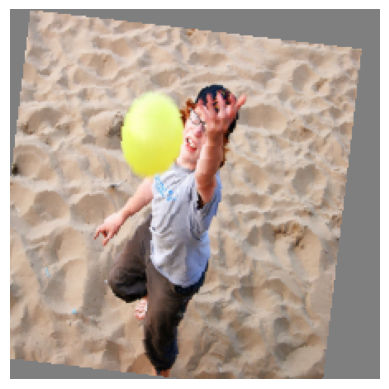

tensor([ 101, 1996, 2711, 2003, 6886, 1037, 3756, 4874, 1999, 1996, 2250, 2096,
        3061, 2006, 5472, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
The person is throwing a yellow object in the air while standing on sand .
['📞' '🧸' '🇧🇷' '🐻\u200d❄️' '🇨🇼']
['telephone receiver' 'teddy bear' 'flag: Brazil' 'polar bear'
 'flag: Curaçao']
[0.63009101 0.564421   0.55173799 0.53398768 0.46307682]


In [ ]:
pd_emoji = pd.read_csv('EmojiDataset/emoji_with_embeddings_distilbert.csv')
# Get emoji embeddings
emoji_embeddings = pd_emoji.iloc[:, 2:].values

# Fetch a batch of images and captions
images, texts, captions = next(iter(train_loader))
id =4

# Get image embedding
model.eval()
model.to(device)
image_features = model.image_encoder(images[id].unsqueeze(0).to(device))
image_embeddings = model.image_projection(image_features)
image_embeddings = F.normalize(image_embeddings, dim=-1).cpu().detach().numpy()
text_features = model.text_encoder(texts[id].unsqueeze(0).to(device))
text_embeddings = model.text_projection(text_features)
text_embeddings = F.normalize(text_embeddings, dim=-1).cpu().detach().numpy()

# Calculate similarity between image and emoji embeddings
similarity = np.dot(image_embeddings, emoji_embeddings.T)

# Show image
plt.imshow(images[id].permute(1, 2, 0)/2+0.5)
plt.axis('off')
plt.show()

# Show caption
print(texts[id])
print(captions[id])

# Get top 5 most similar emojis
top5_idx = np.argsort(similarity[0])[::-1][:5]
top5_emojis = pd_emoji.iloc[top5_idx, 0].values
top5_emoji_captions = pd_emoji.iloc[top5_idx, 1].values
print(top5_emojis)
print(top5_emoji_captions)
print(similarity[0][top5_idx])


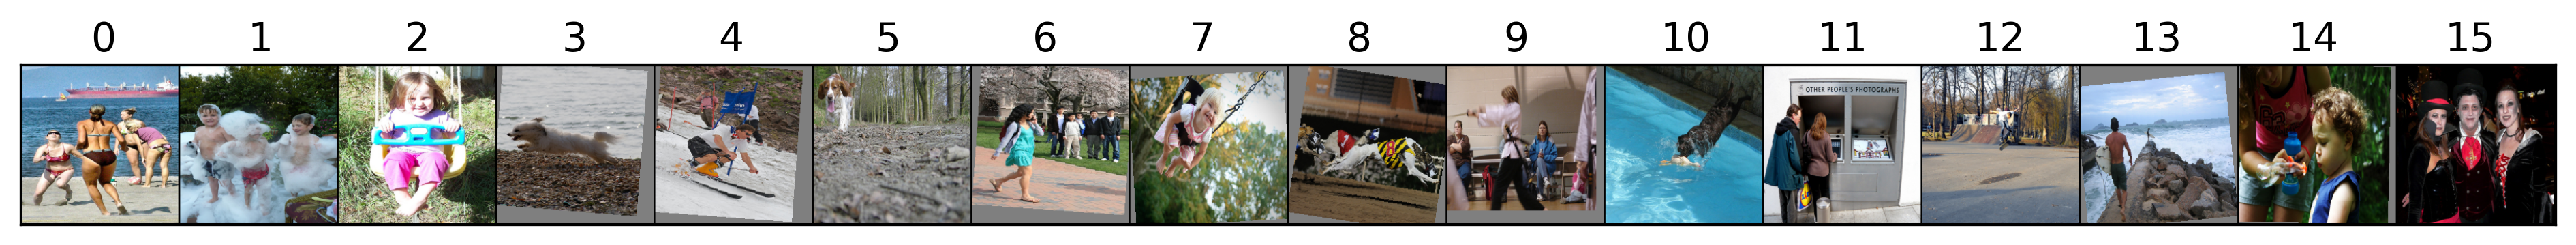

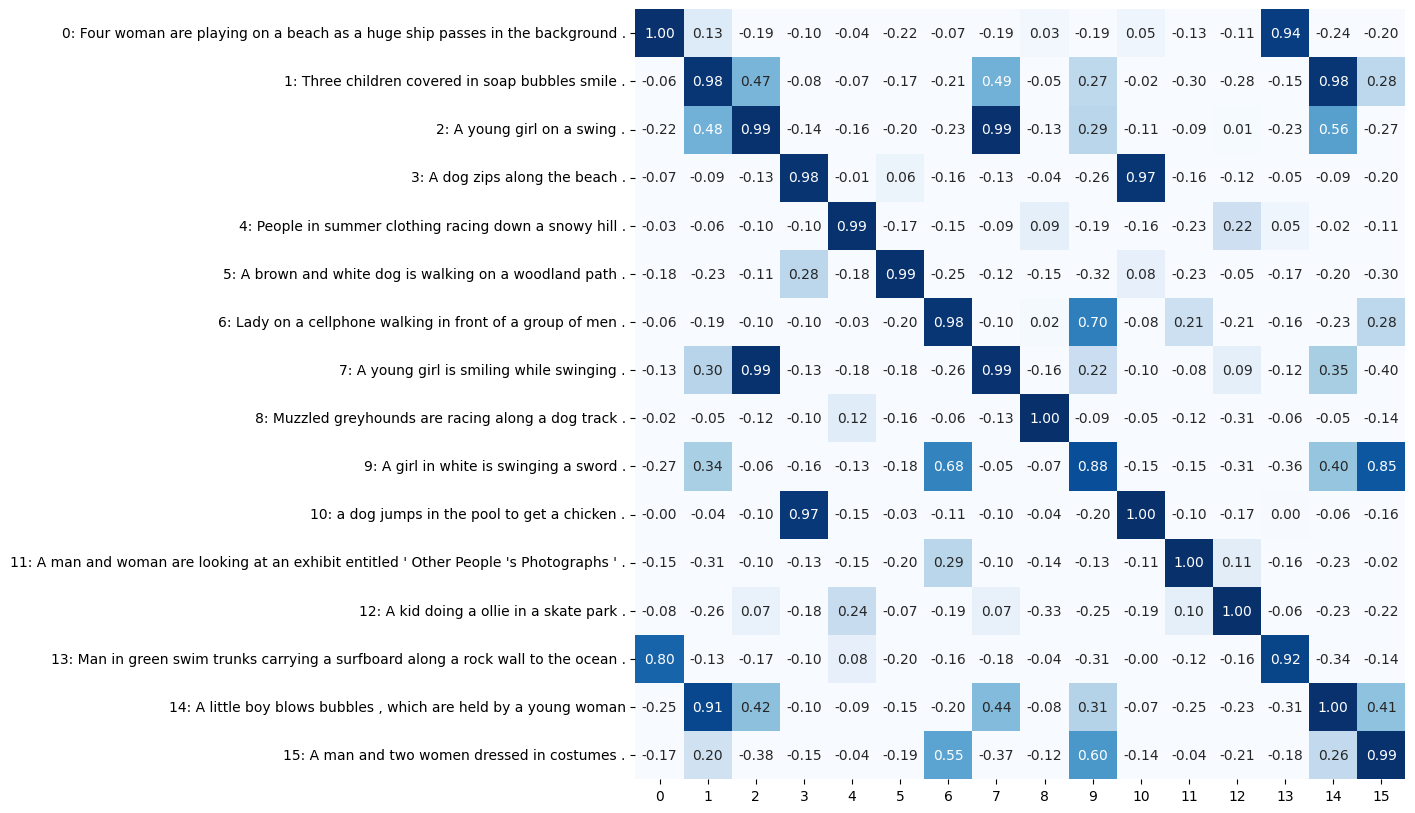

In [ ]:
# Fetch a batch of images and captions
images, texts, captions = next(iter(train_loader))

# show images
row_images = images / 2 + 0.5
fig, ax = plt.subplots(figsize=(bs, bs), dpi=300)
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(row_images.detach()[:row_images.size(0)], nrow=bs).permute(1, 2, 0))
for i in range(row_images.size(0)):
    ax.text(i%bs*224+100, i//bs*224-20, str(i), fontsize=14, color='black')
plt.show()

# show captions and similarity matrix
plt.figure(figsize=(10,10))
image_embeddings, text_embeddings = model((images.to(device), texts.to(device)))
similarity = np.dot(image_embeddings.detach().cpu().numpy(), text_embeddings.detach().cpu().numpy().T)
sns.heatmap(similarity, vmin=0, vmax=1, cmap='Blues', annot=True, square=True, fmt='.2f', cbar=False)
plt.yticks(ticks=np.arange(len(captions))+0.5, labels=[f'{i}: {caption}' for i, caption in enumerate(captions)], rotation=0)
plt.show()

## 📝 Refferences
- [CLIP Paper](https://arxiv.org/abs/2103.00020)
- [CLIP wandb Implementation](https://github.com/soumik12345/clip-lightning)
- [Flickr-8k Dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k)
- [Emoji Dataset](https://huggingface.co/datasets/valhalla/emoji-dataset)

## ☑️ To-Do
- Train the model on a larger dataset Flickr-30k
- Train the model on a larger dataset MS-COCO
- Data Augmentation
- Emoji Feature Space